Upload a ZIP file containing .txt leaflet files.


Saving latvian_communist_leaflets_1934-1935-partly-1936.zip to latvian_communist_leaflets_1934-1935-partly-1936 (3).zip

Some files have print_run = 'unk' (unknown).
Enter integer value to use for each 'unk' (default 1000): 1000
Using unk = 1000 per 'unk' file.


=== Monthly statistics ===
1934-01: total=30500, n=9, mean=3388.9, median=3000.0
1934-02: total=19000, n=7, mean=2714.3, median=3000.0
1934-03: total=16500, n=7, mean=2357.1, median=1000.0
1934-04: total=34400, n=10, mean=3440.0, median=1750.0
1934-05: total=15500, n=7, mean=2214.3, median=1000.0
1934-06: total=2000, n=2, mean=1000.0, median=1000.0
1934-07: total=31000, n=15, mean=2066.7, median=1000.0
1934-08: total=13050, n=8, mean=1631.2, median=1000.0
1934-09: total=15200, n=7, mean=2171.4, median=1000.0
1934-10: total=18300, n=9, mean=2033.3, median=1000.0
1934-11: total=33000, n=8, mean=4125.0, median=3000.0
1934-12: total=14200, n=6, mean=2366.7, median=1250.0
1935-01: total=22350, n=10, mean=2235.0, median=2000.0
1935-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

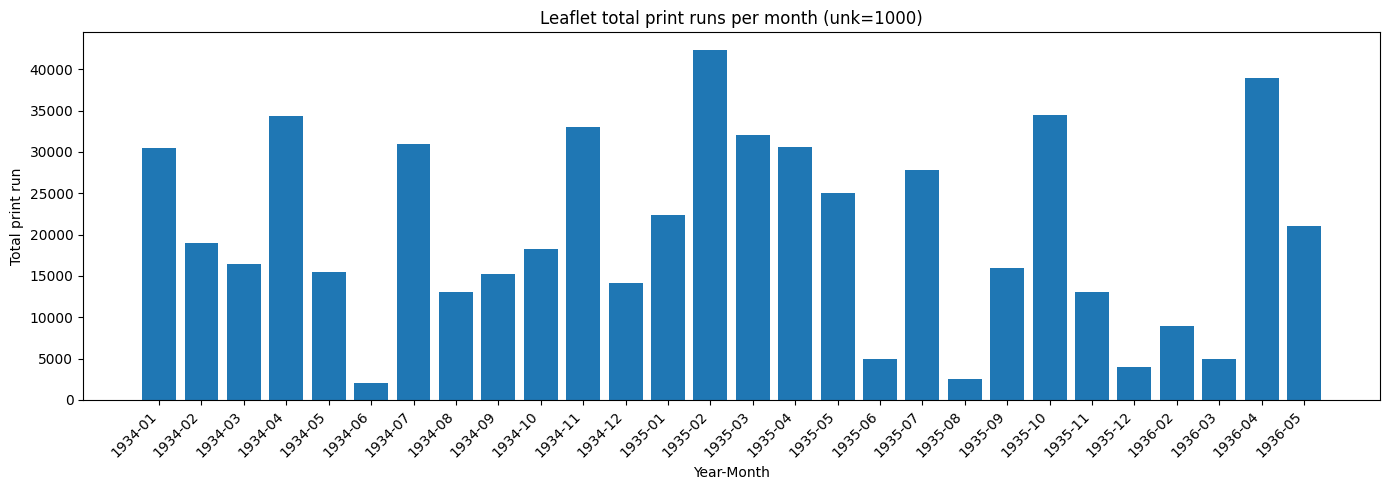


=== Statistical test: Differences between months ===
ANOVA: F = 1.675, p = 0.02907
Kruskal–Wallis: H = 37.106, p = 0.07313
→ No significant difference between months (p ≥ 0.05)


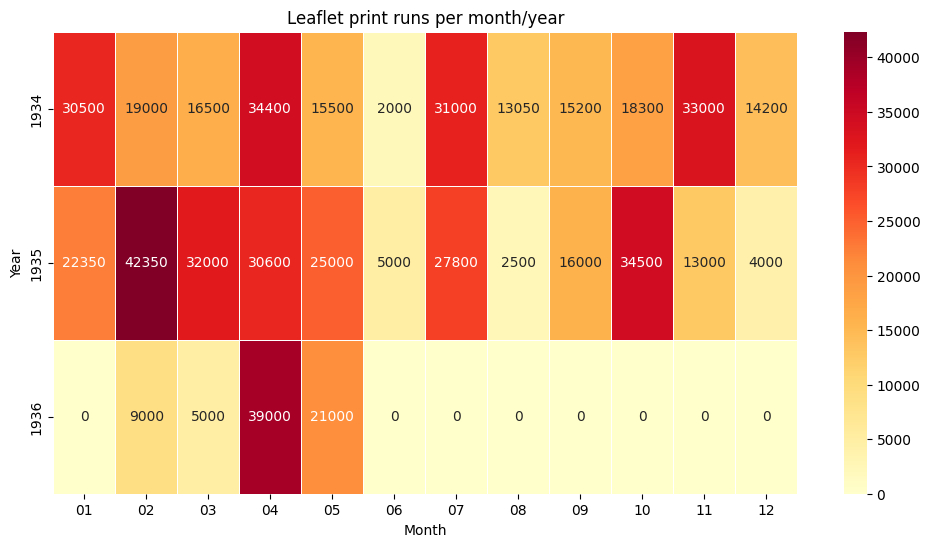

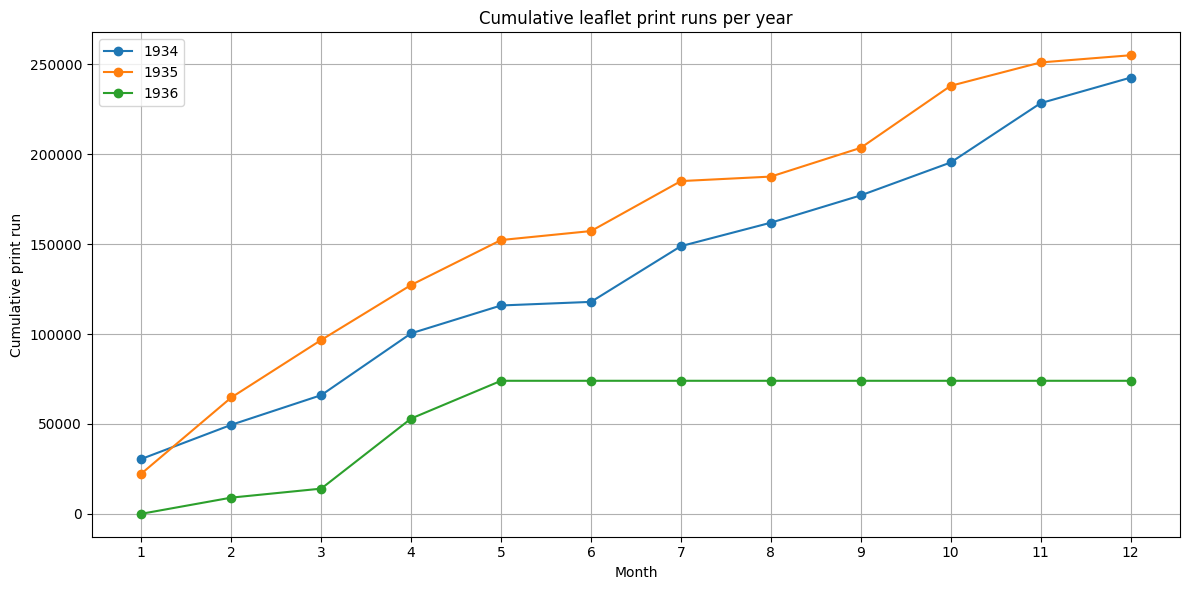

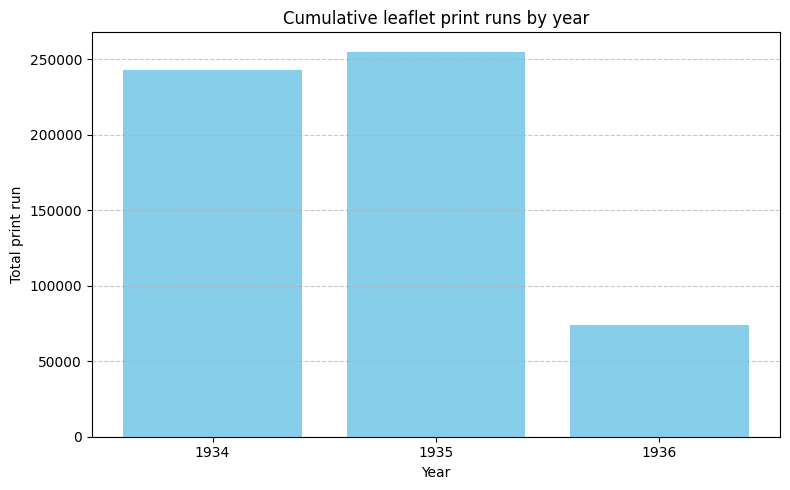

01: mean=2782, median=2000, vals=[5000, 1500, 1000, 3000, 10000, 5000, 3000, 1000, 1000, 5000, 5000, 2000, 1000, 2000, 2000, 250, 2000, 3000, 100]
02: mean=2814, median=3000, vals=[3000, 1000, 6000, 1000, 1000, 4000, 3000, 4000, 4000, 4000, 1000, 1000, 4000, 10000, 1000, 1000, 1000, 7000, 1000, 300, 3000, 50, 4000, 2000, 3000]
03: mean=2675, median=2500, vals=[4000, 5000, 1000, 3500, 1000, 1000, 1000, 5000, 2000, 3000, 3000, 2000, 2000, 4000, 1000, 5000, 5000, 1000, 3000, 1000]
04: mean=4160, median=3000, vals=[1500, 6000, 1000, 10000, 3000, 2000, 500, 10000, 300, 100, 200, 15000, 4000, 5000, 4000, 1000, 500, 100, 800, 10000, 10000, 3000, 10000, 1000, 5000]
05: mean=3618, median=3000, vals=[10000, 3000, 8000, 3000, 500, 1000, 5000, 4000, 1000, 1000, 6000, 5000, 4000, 2000, 3000, 1000, 4000]
06: mean=1750, median=1500, vals=[1000, 1000, 3000, 2000]
07: mean=2450, median=1500, vals=[1000, 1000, 1000, 2000, 5000, 1000, 5000, 3000, 3000, 3000, 1000, 2000, 1000, 1000, 1000, 1000, 1000, 800,

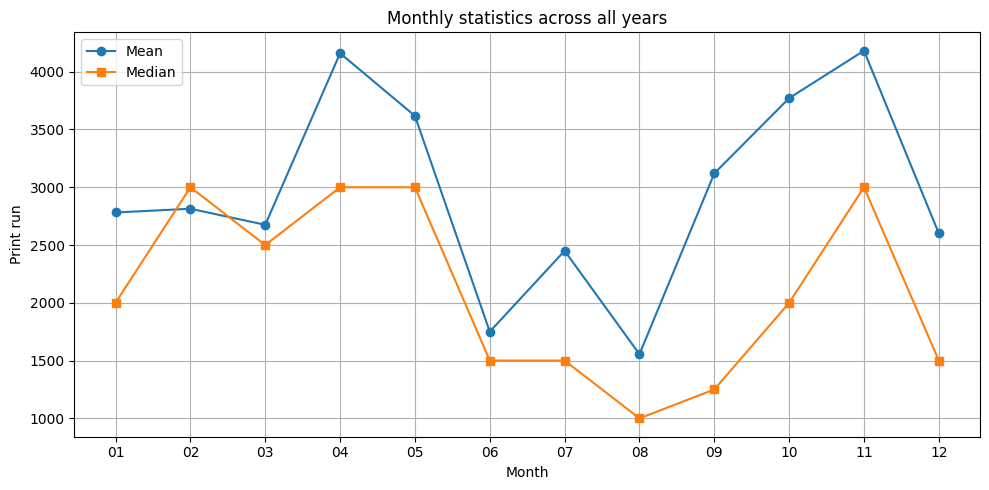

In [5]:
# Leaflet monthly print-run aggregator + basic statistics & visualization
# - Upload a ZIP archive containing .txt files (filenames only are parsed)
# - User defines the value to substitute for unknown print runs ('unk')
# - Aggregates print runs per month (YYYY-MM)
# - Computes mean, median, ANOVA and Kruskal–Wallis tests
# - Saves CSV output and plots bar charts, heatmaps, and cumulative plots

import zipfile
import io
import os
import re
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd

# ---- 1) Upload ZIP file ----
print("Upload a ZIP file containing .txt leaflet files.")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")
zip_name = next(iter(uploaded.keys()))
zip_bytes = uploaded[zip_name]

# ---- 2) Extract filenames from ZIP ----
z = zipfile.ZipFile(io.BytesIO(zip_bytes))
txt_members = [m for m in z.infolist() if m.filename.lower().endswith('.txt')]
if not txt_members:
    raise SystemExit("No .txt files found in ZIP.")
filenames = [os.path.basename(m.filename) for m in txt_members]

# ---- 3) Ask user how to treat unknown print runs ('unk') ----
print("\nSome files have print_run = 'unk' (unknown).")
raw = input("Enter integer value to use for each 'unk' (default 1000): ").strip()
if raw == "":
    unk_value = 1000
else:
    try:
        unk_value = int(raw)
    except ValueError:
        print("Invalid input, using default 1000.")
        unk_value = 1000
print(f"Using unk = {unk_value} per 'unk' file.\n")

# ---- 4) Regex patterns for parsing dates and print runs ----
DATE_RANGE_RE = re.compile(r'(?P<y1>19\d{2})-(?P<m1>\d{2})-(?P<d1>\d{2})\.\.(?P<y2>19\d{2})-(?P<m2>\d{2})-(?P<d2>\d{2})')
DATE_FULL_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})[-_](?P<d>\d{2})')
DATE_YM_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})')
PR_RE = re.compile(r'-(?P<pr>\d{1,6}|unk)(?:[-_\.\[]|$)', flags=re.IGNORECASE)

# ---- Helper functions ----
def extract_print_run(fname):
    """Extracts the print run value from filename, returns int or 'unk'."""
    m = PR_RE.search(fname)
    if not m:
        return None
    pr = m.group('pr')
    if pr.lower() == 'unk':
        return 'unk'
    try:
        return int(pr)
    except:
        return None

def extract_year_month(fname):
    """Extracts YYYY-MM string from filename using different date patterns."""
    m_range = DATE_RANGE_RE.search(fname)
    if m_range:
        return f"{m_range.group('y1')}-{m_range.group('m1')}"
    m_full = DATE_FULL_RE.search(fname)
    if m_full:
        return f"{m_full.group('y')}-{m_full.group('m')}"
    m_ym = DATE_YM_RE.search(fname)
    if m_ym:
        return f"{m_ym.group('y')}-{m_ym.group('m')}"
    return None

# ---- 5) Aggregate print runs by month ----
monthly_totals = defaultdict(int)   # total print run per month
monthly_counts = defaultdict(int)   # number of leaflets per month
monthly_values = defaultdict(list)  # list of all print runs per month
unassigned = []

for fname in filenames:
    pr = extract_print_run(fname)
    ym = extract_year_month(fname)
    if ym is None:
        unassigned.append(fname)
        continue
    val = unk_value if pr == 'unk' else (pr if isinstance(pr, int) else 0)
    monthly_totals[ym] += val
    monthly_counts[ym] += 1
    monthly_values[ym].append(val)

if unassigned:
    print("Files with NO parsed 19xx year-month (skipped):")
    for u in unassigned:
        print("  ", u)
    print()

# ---- 6) Sort months chronologically ----
def ym_sort_key(ym):
    y, m = ym.split('-')
    return (int(y), int(m))
sorted_months = sorted(monthly_totals.keys(), key=ym_sort_key)

# ---- 7) Compute mean & median per month ----
print("\n=== Monthly statistics ===")
summary = []
for ym in sorted_months:
    vals = monthly_values[ym]
    mean = np.mean(vals)
    median = np.median(vals)
    summary.append((ym, monthly_totals[ym], monthly_counts[ym], mean, median))
    print(f"{ym}: total={monthly_totals[ym]}, n={monthly_counts[ym]}, mean={mean:.1f}, median={median}")

# ---- 8) Save CSV ----
csv_path = "monthly_print_runs_with_stats.csv"
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['year_month', 'total_print_run', 'n_leaflets', 'mean_print_run', 'median_print_run'])
    for row in summary:
        writer.writerow(row)
print(f"\nCSV saved to {csv_path}")
files.download(csv_path)

# ---- 9) Bar chart of monthly total print runs ----
labels = sorted_months
values = [monthly_totals[ym] for ym in labels]

plt.figure(figsize=(max(8, len(labels)*0.5), 5))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45, ha='right')
plt.xlabel('Year-Month')
plt.ylabel('Total print run')
plt.title(f'Leaflet total print runs per month (unk={unk_value})')
plt.tight_layout()
plt.show()

# ---- 10) Statistical tests: ANOVA / Kruskal–Wallis ----
print("\n=== Statistical test: Differences between months ===")
groups = [monthly_values[ym] for ym in sorted_months if len(monthly_values[ym]) > 1]
if len(groups) < 2:
    print("Not enough data for statistical test (need ≥2 months with ≥2 values each).")
else:
    f_val, p_val_anova = stats.f_oneway(*groups)
    h_val, p_val_kw = stats.kruskal(*groups)
    print(f"ANOVA: F = {f_val:.3f}, p = {p_val_anova:.5f}")
    print(f"Kruskal–Wallis: H = {h_val:.3f}, p = {p_val_kw:.5f}")
    if p_val_kw < 0.05:
        print("→ Statistically significant difference between months (p < 0.05)")
    else:
        print("→ No significant difference between months (p ≥ 0.05)")

# ---- 11) Heatmap of print runs by month and year ----
month_year_totals = defaultdict(int)
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    month_year_totals[(int(y), int(m))] = sum(vals)

years = sorted(set(y for y, m in month_year_totals.keys()))
months = list(range(1,13))

data = []
for y in years:
    row = [month_year_totals.get((y, m), 0) for m in months]
    data.append(row)

df = pd.DataFrame(data, index=years, columns=[f"{m:02d}" for m in months])

plt.figure(figsize=(12,6))
sns.heatmap(df, annot=True, fmt="g", cmap="YlOrRd", linewidths=0.5)
plt.title("Leaflet print runs per month/year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# ---- 12) Cumulative print runs per year ----
year_month_totals = defaultdict(lambda: [0]*12)
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    year_month_totals[int(y)][int(m)-1] += sum(vals)

plt.figure(figsize=(12,6))
for y, month_totals in sorted(year_month_totals.items()):
    cumulative = np.cumsum(month_totals)
    plt.plot(range(1,13), cumulative, marker='o', label=str(y))

plt.xticks(range(1,13))
plt.xlabel('Month')
plt.ylabel('Cumulative print run')
plt.title('Cumulative leaflet print runs per year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 13) Annual cumulative print runs (simple histogram) ----
annual_totals = defaultdict(int)
for ym, vals in monthly_values.items():
    annual_totals[ym[:4]] += sum(vals)

years_sorted = sorted(annual_totals.keys())
totals_sorted = [annual_totals[y] for y in years_sorted]

plt.figure(figsize=(8,5))
plt.bar(years_sorted, totals_sorted, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total print run')
plt.title('Cumulative leaflet print runs by year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# ---- 14) Aggregate by calendar month across all years ----
# Calculate monthly statistics across all years (for overview, not key for detailed analysis)

month_values = defaultdict(list)
for ym, vals in monthly_values.items():
    month = ym[5:7]  # "01", "02", ..., "12"
    month_values[month].extend(vals)

# ---- Print mean & median across all years by month ----
for m in sorted(month_values.keys()):
    vals = month_values[m]
    if not vals:
        continue
    mean = int(round(np.mean(vals)))
    median = int(round(np.median(vals)))
    print(f"{m}: mean={mean}, median={median}, vals={vals}")

# ---- Plot mean & median per month across all years ----
months = sorted(month_values.keys())
means = [np.mean(month_values[m]) for m in months]
medians = [np.median(month_values[m]) for m in months]

plt.figure(figsize=(10,5))
x = np.arange(len(months))
plt.plot(x, means, marker='o', label='Mean')
plt.plot(x, medians, marker='s', label='Median')
plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('Print run')
plt.title('Monthly statistics across all years')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
